# VGG-16 pretrained model

- bottleneck features cached, and train a small nn with bottleneck features.
- no data augmentation.
- The prediction process is revised, so that one crop 9x9 images to make a compound prediction of the test data.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import cv2
import math
from glob import glob
import os
import sys
import pickle

# Preprocessing the training images

Prediction labels for training set.

In [2]:
master = pd.read_csv("../input/train_labels.csv")

Get input image file paths.

In [3]:
img_path = "../input/train/"

y = []
file_paths = []
for i in range(len(master)):
    file_paths.append( img_path + str(master.iloc[i, 0]) +'.jpg' ) # .ix same as .iloc
    y.append(master.iloc[i,1])
print('fnames: {}'.format(file_paths[:10]))
print('labels: {}'.format(y[:10]))
y = np.array(y)

fnames: ['../input/train/1.jpg', '../input/train/2.jpg', '../input/train/3.jpg', '../input/train/4.jpg', '../input/train/5.jpg', '../input/train/6.jpg', '../input/train/7.jpg', '../input/train/8.jpg', '../input/train/9.jpg', '../input/train/10.jpg']
labels: [0, 0, 1, 0, 1, 0, 1, 1, 0, 0]


Preprocessing training images.

In [4]:
#image resize & centering & crop 

def centering_image(img):
    size = [256,256]
    
    img_size = img.shape[:2]
    
    # centering
    row = (size[1] - img_size[0]) // 2
    col = (size[0] - img_size[1]) // 2
    resized = np.zeros(list(size) + [img.shape[2]], dtype=np.uint8)
    resized[row:(row + img.shape[0]), col:(col + img.shape[1])] = img

    return resized


X = []
for i, file_path in enumerate(file_paths):
    sys.stdout.write("\r {0} from total {1} images".format(file_path, len(file_paths)))
    sys.stdout.flush()
    #read image
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    #resize
    if(img.shape[0] > img.shape[1]):
        tile_size = (int(img.shape[1]*256/img.shape[0]),256)
    else:
        tile_size = (256, int(img.shape[0]*256/img.shape[1]))
    img = cv2.resize(img, dsize=tile_size)

    #centering
    img = centering_image(img)

    #out put 224*224px 
    img = img[16:240, 16:240]

    X.append(img)

X = np.array(X)

 ../input/train/2295.jpg from total 2295 images

# Find file_path for test images and preprocessing

Find all test image file path_file names.

In [5]:
sample_submission = pd.read_csv("../input/sample_submission.csv")
img_path = "../input/test/"

test_names = []
file_paths = []

for i in range(len(sample_submission)):
    test_names.append(sample_submission.iloc[i,0])
    file_paths.append( img_path + str(int(sample_submission.iloc[i,0])) +'.jpg' )

print('test file path: {}'.format(file_paths[:10]))    
test_names = np.array(test_names)

test file path: ['../input/test/1.jpg', '../input/test/2.jpg', '../input/test/3.jpg', '../input/test/4.jpg', '../input/test/5.jpg', '../input/test/6.jpg', '../input/test/7.jpg', '../input/test/8.jpg', '../input/test/9.jpg', '../input/test/10.jpg']


Preprocess test images.

In [39]:
test_images = []
for file_path in file_paths:
    sys.stdout.write("\r {0} from total {1} images".format(file_path, len(file_paths)))
    sys.stdout.flush()
    #read image
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ll, ww = img.shape[0]//3, img.shape[1]//3
    sub_images = []
    for i in range(3):
        for j in range(3):
            sub_img = img[i*ll:(i+1)*ll, j*ww:(j+1)*ww, :]

            #resize
            if(sub_img.shape[0] > sub_img.shape[1]):
                tile_size = (int(sub_img.shape[1]*256/sub_img.shape[0]),256)
            else:
                tile_size = (256, int(sub_img.shape[0]*256/sub_img.shape[1]))

            #centering
            sub_img = centering_image(cv2.resize(sub_img, dsize=tile_size))
    
            #output 224*224px 
            sub_img = sub_img[16:240, 16:240]
            sub_images.append(sub_img)
    test_images.append(sub_images)

test_images = np.array(test_images)

 ../input/test/1531.jpg from total 1531 images

In [40]:
inshape = test_images.shape
inshape

(1531, 9, 224, 224, 3)

# Train-Validation splitting

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2017)

print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_val', X_val.shape)
print('y_val', y_val.shape)

X_train (1836, 224, 224, 3)
y_train (1836,)
X_val (459, 224, 224, 3)
y_val (459,)


Normalized to put into vgg.

In [9]:
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_train /= 255
X_val /= 255

# Using Keras VGG-16 pretrained model

## Loading VGG-16 pretrained model in Keras

In [10]:
from keras.models import Sequential, Model, load_model
from keras import applications
from keras import optimizers
from keras.layers import Dropout, Flatten, Dense

img_rows, img_cols, img_channel = 224, 224, 3

vgg16 = applications.VGG16(weights='imagenet', include_top=True, input_shape=(img_rows, img_cols, img_channel))

Using TensorFlow backend.


In [11]:
vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## Build feature extractor using low-level layers up to `fc2` Dense layer

In [12]:
preds = vgg16.get_layer('fc2').output

In [13]:
feat_extractor = Model(vgg16.input, preds)

## Sample feature generated from the feature extractor

In [14]:
sample_feat = feat_extractor.predict(X_train[1].reshape((1,) + X_train[1].shape))

In [15]:
sample_feat.shape

(1, 4096)

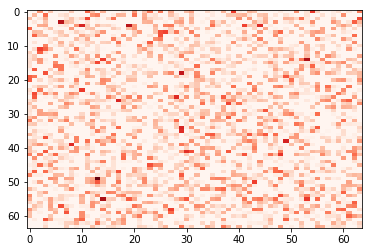

In [16]:
img_tmp = sample_feat
img_tmp = img_tmp.reshape((-1, 64))
plt.imshow(img_tmp, interpolation='nearest', cmap='Reds', aspect='auto')
plt.show()

# Calculate transfer values and dump to file

In [17]:
data_path = '../input/'
file_path_cache_train = os.path.join(data_path, 'vgg16_invasive_train.pkl')
file_path_cache_val = os.path.join(data_path, 'vgg16_invasive_val.pkl')

In [18]:
# calculate tranfer values and cache to file
def transfer_values_cache(images, image_path, model):
    if os.path.exists(image_path):
        with open(image_path, mode='rb') as file:
            transfer_values = pickle.load(file)
        print("- Data loaded from cache file: {}".format(image_path))
    else:
        sample_size = images.shape[0]
        transfer_values = process_images(images, model)
        transfer_values = transfer_values.reshape(sample_size, -1)
        with open(image_path, mode='wb') as file:
            pickle.dump(transfer_values, file)
        print("- Data saved to cache file: {}".format(image_path))
    
    return transfer_values

def process_images(images, model):
    num_images = images.shape[0]
    res = [None] * num_images
    for i in range(num_images):
        msg = "\r- Processing image: {0:>6} / {1}".format(i+1, num_images)
        sys.stdout.write(msg)
        sys.stdout.flush()
        
        res[i] = model.predict(images[i].reshape((1,) + images[i].shape))
    print()
    res = np.array(res)
    return res

In [19]:
transfer_values_train = transfer_values_cache(X_train, file_path_cache_train, feat_extractor)
transfer_values_val = transfer_values_cache(X_val, file_path_cache_val, feat_extractor)

- Data loaded from cache file: ../input/vgg16_invasive_train.pkl
- Data loaded from cache file: ../input/vgg16_invasive_val.pkl


# Analysis of transfer values

## PCA analysis

Different classes still mixed in PCA feature

In [20]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

cls = y_train
print(transfer_values_train.shape)

transfer_values_reduced = pca.fit_transform(transfer_values_train)
print(transfer_values_reduced.shape)

(1836, 4096)
(1836, 2)


In [21]:
num_classes = 2
def plot_scatter(values, cls):
    # Create a color-map with a different color for each class.
    import matplotlib.cm as cm
    cmap = cm.rainbow(np.linspace(0.0, 1.0, num_classes))

    # Get the color for each sample.
    colors = cmap[cls]

    # Extract the x- and y-values.
    x = values[:, 0]
    y = values[:, 1]

    # Plot it.
    plt.scatter(x, y, color=colors)
    plt.show()

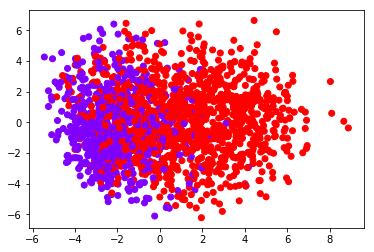

In [22]:
plot_scatter(transfer_values_reduced, cls)

## t_SNE analysis

In [23]:
from sklearn.manifold import TSNE

pca = PCA(n_components=200)
transfer_values_50d = pca.fit_transform(transfer_values_train)

tsne = TSNE(n_components=2)
transfer_values_reduced = tsne.fit_transform(transfer_values_50d) 

transfer_values_reduced.shape

(1836, 2)

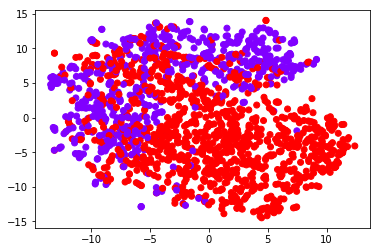

In [24]:
plot_scatter(transfer_values_reduced, cls)

# New neural network classifier

## Model building

In [25]:
nn = Sequential()
nn.add(Dense(256, input_dim=transfer_values_train.shape[1], activation='relu'))
nn.add(Dropout(0.5))
nn.add(Dense(1, activation='sigmoid'))
nn.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=1e-3, decay=0.5), metrics=['accuracy'])

## Model training

In [26]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

batch_size = 32
epochs = 50

history = nn.fit(
    transfer_values_train, y_train, batch_size=batch_size,
    epochs=epochs,
    validation_data=(transfer_values_val, y_val),
    verbose=2,
    callbacks=[ModelCheckpoint('VGG16-transferlearning.model', monitor='val_acc', save_best_only=True)])

Train on 1836 samples, validate on 459 samples
Epoch 1/50
1s - loss: 0.8623 - acc: 0.5942 - val_loss: 0.5589 - val_acc: 0.6013
Epoch 2/50
1s - loss: 0.6154 - acc: 0.6694 - val_loss: 0.5529 - val_acc: 0.6013
Epoch 3/50
1s - loss: 0.5733 - acc: 0.6961 - val_loss: 0.5016 - val_acc: 0.7647
Epoch 4/50
0s - loss: 0.5367 - acc: 0.7200 - val_loss: 0.5024 - val_acc: 0.7364
Epoch 5/50
0s - loss: 0.5127 - acc: 0.7402 - val_loss: 0.4871 - val_acc: 0.7734
Epoch 6/50
0s - loss: 0.5129 - acc: 0.7418 - val_loss: 0.4834 - val_acc: 0.7734
Epoch 7/50
1s - loss: 0.4964 - acc: 0.7593 - val_loss: 0.4784 - val_acc: 0.7865
Epoch 8/50
1s - loss: 0.5037 - acc: 0.7380 - val_loss: 0.4692 - val_acc: 0.7952
Epoch 9/50
0s - loss: 0.4838 - acc: 0.7653 - val_loss: 0.4787 - val_acc: 0.7734
Epoch 10/50
0s - loss: 0.4856 - acc: 0.7598 - val_loss: 0.4735 - val_acc: 0.7865
Epoch 11/50
0s - loss: 0.4848 - acc: 0.7647 - val_loss: 0.4695 - val_acc: 0.7908
Epoch 12/50
1s - loss: 0.4749 - acc: 0.7642 - val_loss: 0.4665 - val_ac

In [27]:
del transfer_values_train, transfer_values_val

In [28]:
del X, y, X_train, y_train, X_val, y_val

# Prediction on test data

In [31]:
test_images = test_images.reshape((-1,) + test_images.shape[-3:])

(13779, 224, 224, 3)


In [35]:
import dask.array as da
test_images_dask = da.from_array(test_images, chunks=(1, 224, 244, 3))
test_images_dask = test_images_dask.astype(np.float32)
test_images_dask /= 255.0

In [36]:
file_path_cache_test = os.path.join(data_path, 'vgg16_invasive_test.pkl')
transfer_values_test = transfer_values_cache(test_images, file_path_cache_test, feat_extractor)

- Processing image:  13779 / 13779
- Data saved to cache file: ../input/vgg16_invasive_test.pkl


In [37]:
test_preds = nn.predict(transfer_values_test)

In [41]:
test_preds = test_preds.reshape(inshape[:2])

In [42]:
test_preds = np.amax(test_preds, axis=1)

In [43]:
test_preds[:10]

array([ 0.99798656,  0.98918205,  0.85083729,  0.95528501,  0.99858224,
        0.92645794,  0.9485932 ,  0.99992204,  0.99995911,  0.98953784], dtype=float32)

## Write predictions to file

In [44]:
sample_submission = pd.read_csv("../input/sample_submission.csv")

for i, name in enumerate(test_names):
    sample_submission.loc[sample_submission['name'] == name, 'invasive'] = test_preds[i]

sample_submission.to_csv("submit.csv", index=False)

# Conclusion

Interestingly, even though, the trained nn model with bottle-neck feature inputs only leads to a best accuracy of 0.79, the prediction on test images based on 9x9 cropping gives a final lead board score of 0.878. This is much higher than the valdiation predictions.